## Imports

In [ ]:
# DATA MANIPULATION
import numpy as np

# DATA VISUALIZATION
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler

# BLOB DATASET
from sklearn.datasets import make_blobs

# KERAS
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

# How to Properly Prevent Overfitting

**Goals**
- **`Cross Validate`** a Deep Learning Model
- Give a **`Validation Set`** to the model
- Apply two techniques to prevent overfitting:
    - Use the **`Early Stopping`** criterion to prevent the Neural network from over-learning / over-fitting
    - **`Regularize`** your network
- Analyze the **`impact of the batch size and the number of epochs`** on the training of a Neural Network

## Data - the `blobs` Dataset

### Generating a Blobs Dataset

Generate some data using the [`make_blobs`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html) function from Scikit-Learn

Generate 2000 samples with 10 features each; there should be 8 classes of blobs (`centers` argument) with `cluster_std` equal to 7.

In [ ]:
X, y = make_blobs(
    n_samples=2000, 
    n_features=10, 
    centers=8, 
    cluster_std=7
)

### Visualizing the Dataset

All your samples have 10 features. Plot one of the dimensions against another.

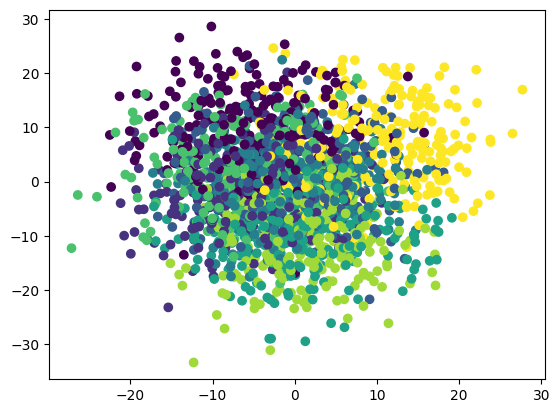

In [ ]:
plt.scatter(X.T[0], X.T[1], c=y)

### Encoding your Categorical Target

Use the [**to_categorical()**](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical) function to convert `y` to `y_cat`, which is the categorical representation of `y` with **One-Hot encoded** columns.

In [ ]:
y_cat = to_categorical(y)

In [ ]:
y

array([2, 4, 7, ..., 0, 3, 4])

In [ ]:
y_cat

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

## (1) Cross-Validation in Deep Learning

### Designing a Neural Network

Write a function that generates a Neural Network with 3 layers:

<u>Architecture</u>
- an **input layer** with 25 neurons, the `relu` activation function and the appropriate `input_dim`
- a **hidden layer** with 10 neurons and the `relu` activation function.
- a **predictive layer** that is suited to the problem at hand (*multiclass classification*)

<u>Compilation</u>

The function should include a compilation method with:
- the *categorical_crossentropy* loss
- the *Adam* optimizer 
- the *accuracy* metric

In [ ]:
def initialize_model():
    #             1 - Model Architecture             #

    model = models.Sequential()
    model.add(layers.Dense(25, activation = 'relu', input_dim = 10))   # INPUT LAYER
    model.add(layers.Dense(10, activation = 'relu'))                                 # HIDDEN LAYER
    model.add(layers.Dense(8, activation = 'softmax'))                           # PREDICTIVE LAYER
    
    #                 2 - Model Compiler              #

    model.compile(
        loss = 'categorical_crossentropy',
        optimizer = 'adam',
        metrics = ['accuracy']
    )

    return model

### Cross-Validating the Neural Net

Write a _loop_ using the [K-Fold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) function from Scikit-Learn.

*  Choose 10 splits to fit your model on the training data
*  Evaluate your model on the testing data, and store the results of the evaluation into a `results` variable.


In [ ]:
# %%time

# kf = KFold(n_splits=10)
# kf.get_n_splits(X)

# results = []

# for train_index, test_index in kf.split(X):
#     # Split the data into train and test


#     # Scaling your data


#     # Initialize the model


#     # Fit the model on the train data


#     # Evaluate the model on the test data


In [ ]:
%%time

kf = KFold(n_splits=10)
kf.get_n_splits(X)

results = []

for train_index, test_index in kf.split(X):
    # Split the data into train and test
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y_cat[train_index], y_cat[test_index]

    # Scale the data
    SScaler = StandardScaler()
    SScaler.fit(X_train)

    X_train_scaled = SScaler.transform(X_train)
    X_test_scaled = SScaler.transform(X_test)

    # Initialize the model
    model = initialize_model()

    # Fit the model on the training data
    model.fit(
        X_train_scaled, 
        y_train,
        epochs = 150,
        batch_size = 16, 
        verbose = 0
    )

    # Evaluate the model on the testing data
    res = model.evaluate(X_test_scaled, y_test, verbose = 0)
    results.append(res)

CPU times: user 5min 13s, sys: 2min 37s, total: 7min 50s
Wall time: 2min 33s


### Performance of the Cross-Validated Network

Print the average accuracy of these 10 folds and the standard deviation of these 10 accuracy values.

In [ ]:
accuracy = [_[1] for _ in results]

print(f'New mean accuracy: {np.mean(accuracy)*100:.2f}% (±{np.std(accuracy)*100:.2f})')

New mean accuracy: 75.45% (±2.50)


### Holdout Method

For the rest of the exercise (and of the Deep Learning module), split the dataset into a training set and a testing set with a 70/30% training-to-test data ratio.

Scale the data after splitting

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size = 0.3)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1400, 10), (600, 10), (1400, 8), (600, 8))

In [ ]:
# Scale the data
SScaler = StandardScaler()
SScaler.fit(X_train)

X_train_scaled = SScaler.transform(X_train)
X_test_scaled = SScaler.transform(X_test)

## (2) How to Prevent a Neural Network from Overfitting?

### (2.1) Early Stopping

 **Stop the learning process before overfitting**

#### Illustrating How a Neural Network Easily Overfits

If we train the model for too long (= for too many epochs) it will overfit the training data and will not be good at predicting the testing data.

**How can we do it without using the testing data, which is strictly forbidden?**

You can use a fraction of the <font color=blue>training set</font> as a <font color=green>validation set</font>.

<img src="https://wagon-public-datasets.s3.amazonaws.com/data-science-images/lectures/deep-learning/02/validation_set.png" width=450>

With Keras, you don't have to re-use the `train_test_split` method from Scikit-Learn. Instead, you have two options:

- `validation_split = 0.2` (for example)
    - The model will take the last 20% of the observations in the training set and use this group as the validation holdout set
    - If you want a random `train_val_split` within the training set, you can also add the argument `shuffle = True` in `model.fit()`
- `validation_data = (X_val, y_val)` if you have access to a dataset that you want to use as the validation holdout set.

Set `epochs = 500`. 

Store the performances of the model in a `history` variable.

In [ ]:
%%time
# 1. Re-initializing your Neural Network
model = initialize_model()

# 2. Fitting it on the training data
history = model.fit(
    X_train_scaled,
    y_train,
    validation_split = 0.3,
    shuffle = True,
    epochs = 500,
    batch_size = 16, 
    verbose = 0
)

2023-02-16 10:47:24.661978: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-16 10:47:25.374671: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


CPU times: user 5min 43s, sys: 1min 33s, total: 7min 17s
Wall time: 6min 8s


#### Your Neural Network's Performance

Evaluate the model on the testing set and print the accuracy.

In [ ]:
results = model.evaluate(X_test_scaled, y_test, verbose=0)

print(f'The accuracy on the test set is of {results[1]:.2f}')

The accuracy on the test set is of 0.72


#### Learnings About Number of Epochs

Plot the history of the model with the `plot_loss_accuracy()` function that we coded for you.

In [ ]:
def plot_loss_accuracy(history, title=None):
    fig, ax = plt.subplots(1,2, figsize=(20,7))

    # --- LOSS --- 

    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])

    ax[0].set_title('Model loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')

    ax[0].set_ylim((0,3))

    ax[0].legend(['Train', 'Test'], loc='best')

    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)

    # --- ACCURACY

    ax[1].plot(history.history['accuracy'])
    ax[1].plot(history.history['val_accuracy'])

    ax[1].set_title('Model Accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')

    ax[1].legend(['Train', 'Test'], loc='best')

    ax[1].set_ylim((0,1))

    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)

    if title:
        fig.suptitle(title)

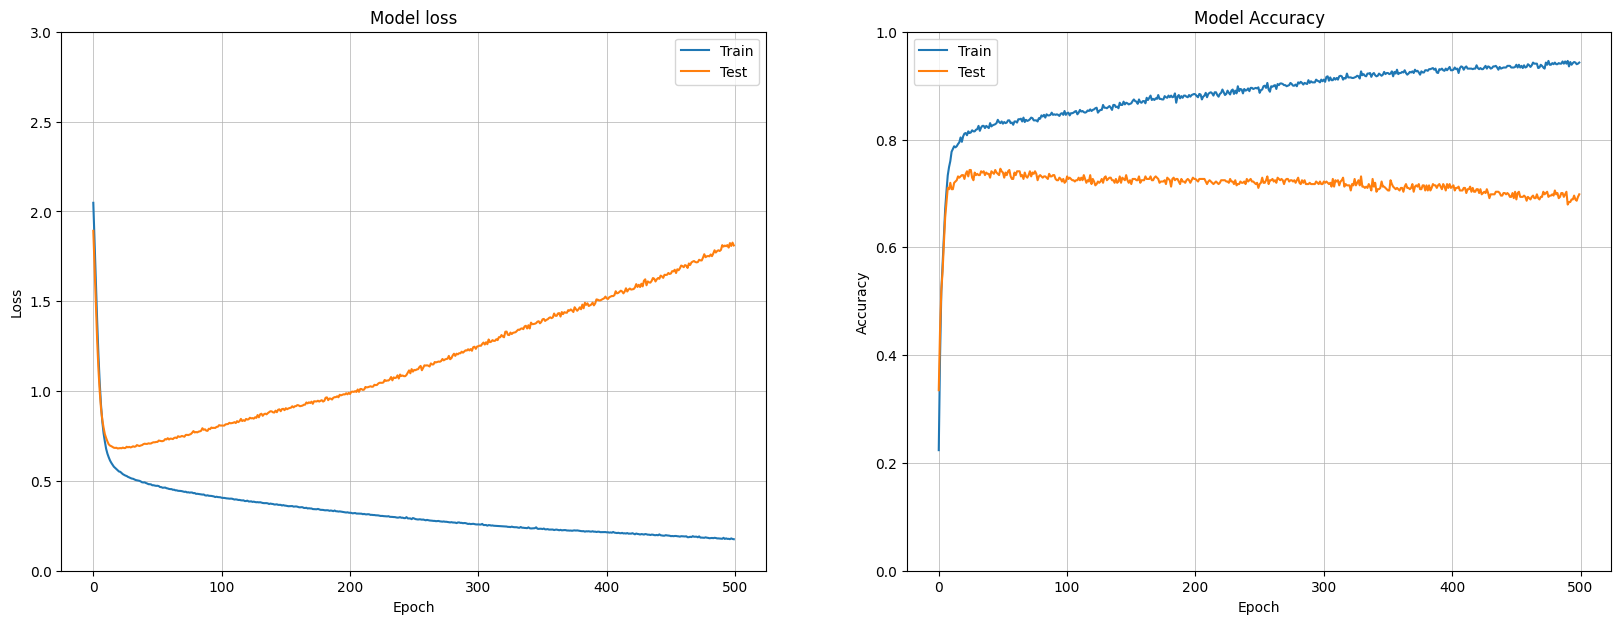

In [ ]:
plot_loss_accuracy(history)

We see that **the number of epochs we choose has a strong influence on the final results**: 

**INSUFFICIENT NUMBER OF EPOCHS $\implies$ UNDERFITTING**:
- The algorithm is not optimal as its Loss Function has **not converged yet**
- It hasn't learned enough from the training data

**TOO MANY EPOCHS** $\implies$ **OVERFITTING**: 
- Our Neural Network has **learned too much** from the training data, including its noisy information
- the algorithm **does not generalize well** on test data

What we want to do is stop the algorithm **when the test loss is minimal** (or when the testing metrics are maximal)

#### Early Stopping

Let's introduce the **Early Stopping** criterion.

The Early Stopping criterion is a way to **automatically stop the training of the algorithm** before reaching the number of epochs that was originally set.


##### Observing the Early Stopping Criterion

Run the following code and plot the history.

In [ ]:
%%time

es = EarlyStopping()

model = initialize_model()

# Fit the model on the train data
history = model.fit(
    X_train_scaled,
    y_train,
    validation_split = 0.3,
    epochs = 500,
    batch_size = 16, 
    verbose = 1, 
    callbacks = [es] # This will call the Early Stopping Criterion for each epoch
)

Epoch 1/500
 6/62 [=>............................] - ETA: 0s - loss: 2.1217 - accuracy: 0.1458 

2023-02-16 10:53:33.246842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


60/62 [============================>.] - ETA: 0s - loss: 2.0355 - accuracy: 0.1854

2023-02-16 10:53:33.998253: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


62/62 [==============================] - 1s 15ms/step - loss: 2.0311 - accuracy: 0.1910 - val_loss: 1.9354 - val_accuracy: 0.2589
Epoch 2/500
62/62 [==============================] - 1s 13ms/step - loss: 1.8584 - accuracy: 0.3054 - val_loss: 1.7741 - val_accuracy: 0.3824
CPU times: user 2.07 s, sys: 449 ms, total: 2.52 s
Wall time: 2 s


##### Evaluate the ES Model

_(also look at the historical losses)_

The accuracy on the test set is of 0.35


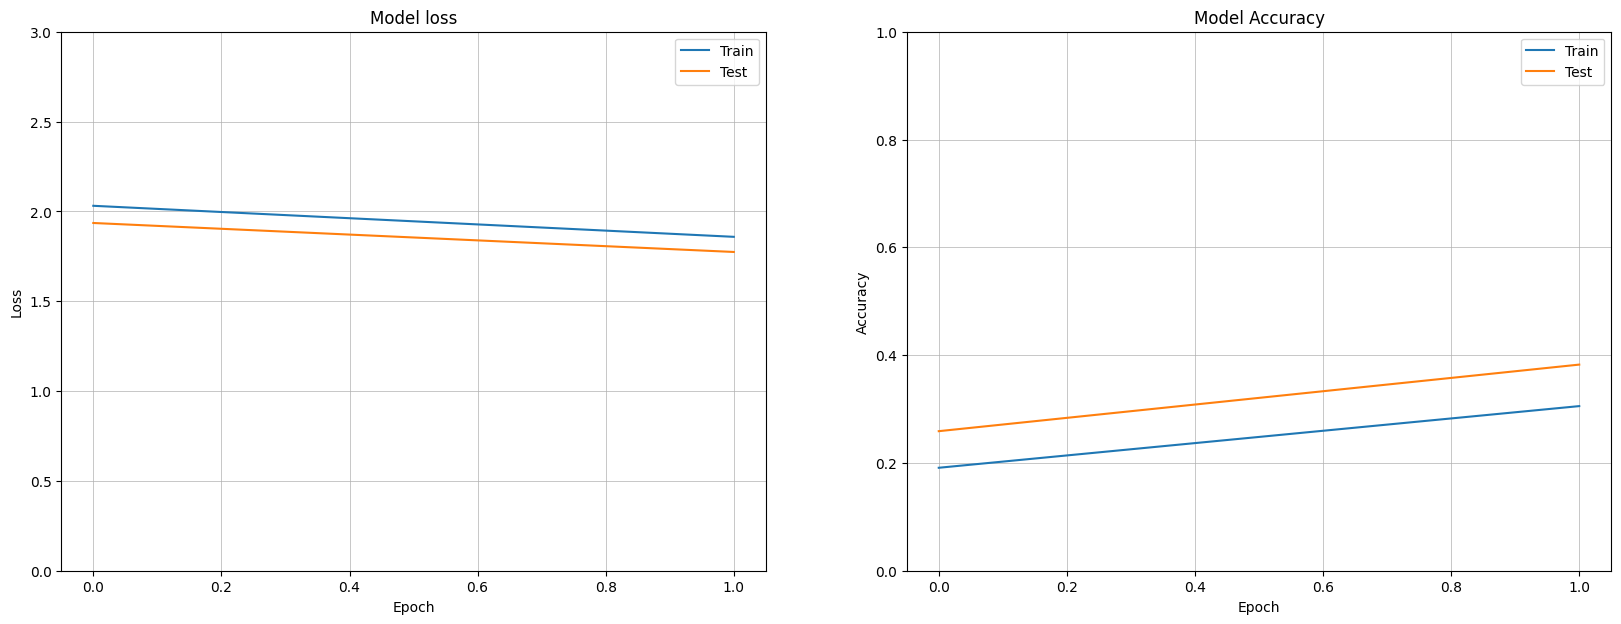

In [ ]:
plot_loss_accuracy(history)

results = model.evaluate(X_test_scaled, y_test, verbose = 0)
print(f'The accuracy on the test set is of {results[1]:.2f}')

In [ ]:
history.history

{'loss': [2.0311312675476074, 1.8584253787994385],
 'accuracy': [0.1910112500190735, 0.30541369318962097],
 'val_loss': [1.935441255569458, 1.774120569229126],
 'val_accuracy': [0.25890737771987915, 0.3824228048324585]}


The `EarlyStopping` criterion has a `patience` keyword that defines how many **consecutive epochs without any loss decrease** are allowed in the validation set before we stop the training procedure.

Use the `EarlyStopping` criterion with a patience term of 30 epochs, plot the results, and print the accuracy on the testing set

2023-02-16 10:53:35.649596: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-16 10:53:36.356339: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


The accuracy on the test set is of 0.76
CPU times: user 34.2 s, sys: 8.9 s, total: 43.1 s
Wall time: 36.2 s


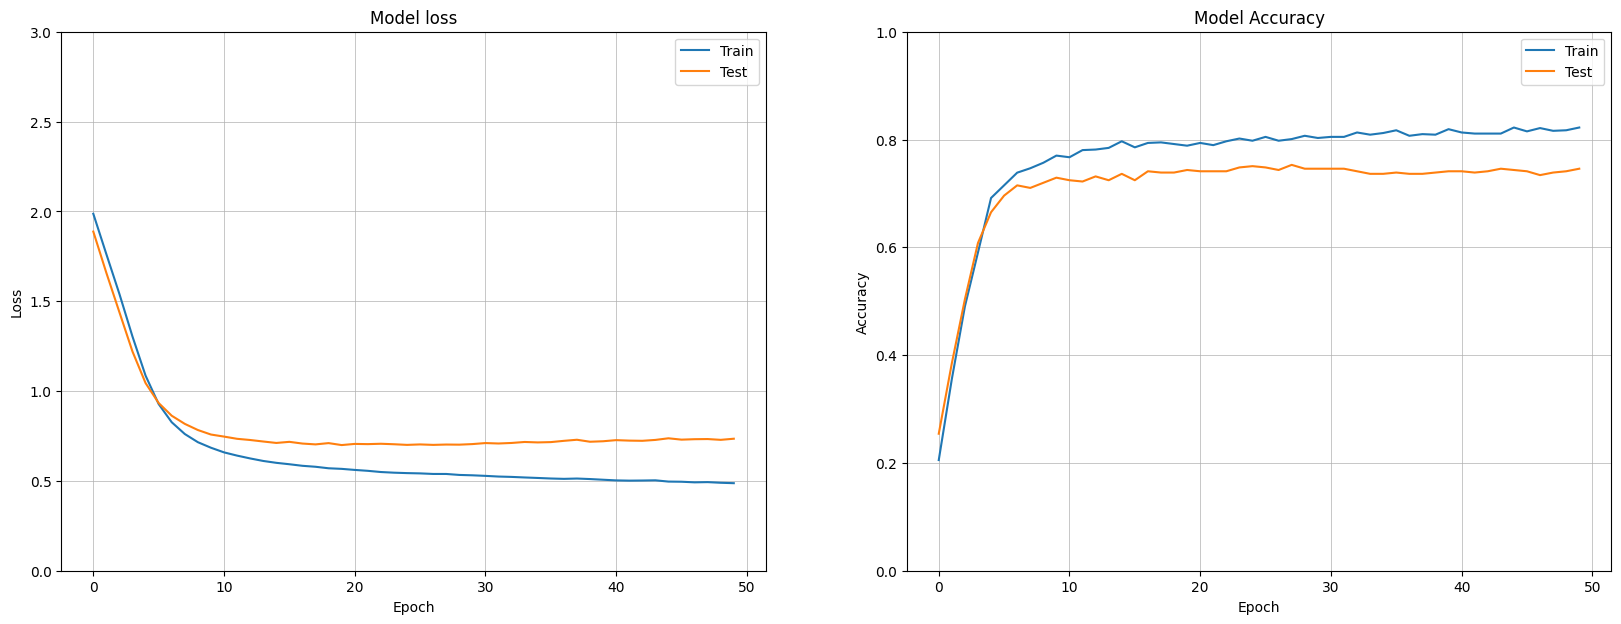

In [ ]:
%%time
# Initializing the Neural Network
model = initialize_model()

# Setting the patience term
es = EarlyStopping(patience=30)

# Fitting the model and saving the training into a history variable
history = model.fit(
    X_train_scaled,
    y_train,
    validation_split = 0.3,
    epochs = 500,
    batch_size = 16, 
    verbose = 0, 
    callbacks = [es]
)


# Observing the loss and the metrics w.r.t. epochs
plot_loss_accuracy(history)

# Evaluating the model on the testing set
results = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f'The accuracy on the test set is of {results[1]:.2f}')

##### Restoring the Best Weights of a Model

- Run the model with an Early Stopping criterion that will restore the best weights of the Neural Net
- Plot the loss and accuracy 
- Print the accuracy on the testing set

2023-02-16 10:54:12.200917: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-16 10:54:12.937528: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


The accuracy on the test set is of 0.77
CPU times: user 37.9 s, sys: 9.69 s, total: 47.6 s
Wall time: 40 s


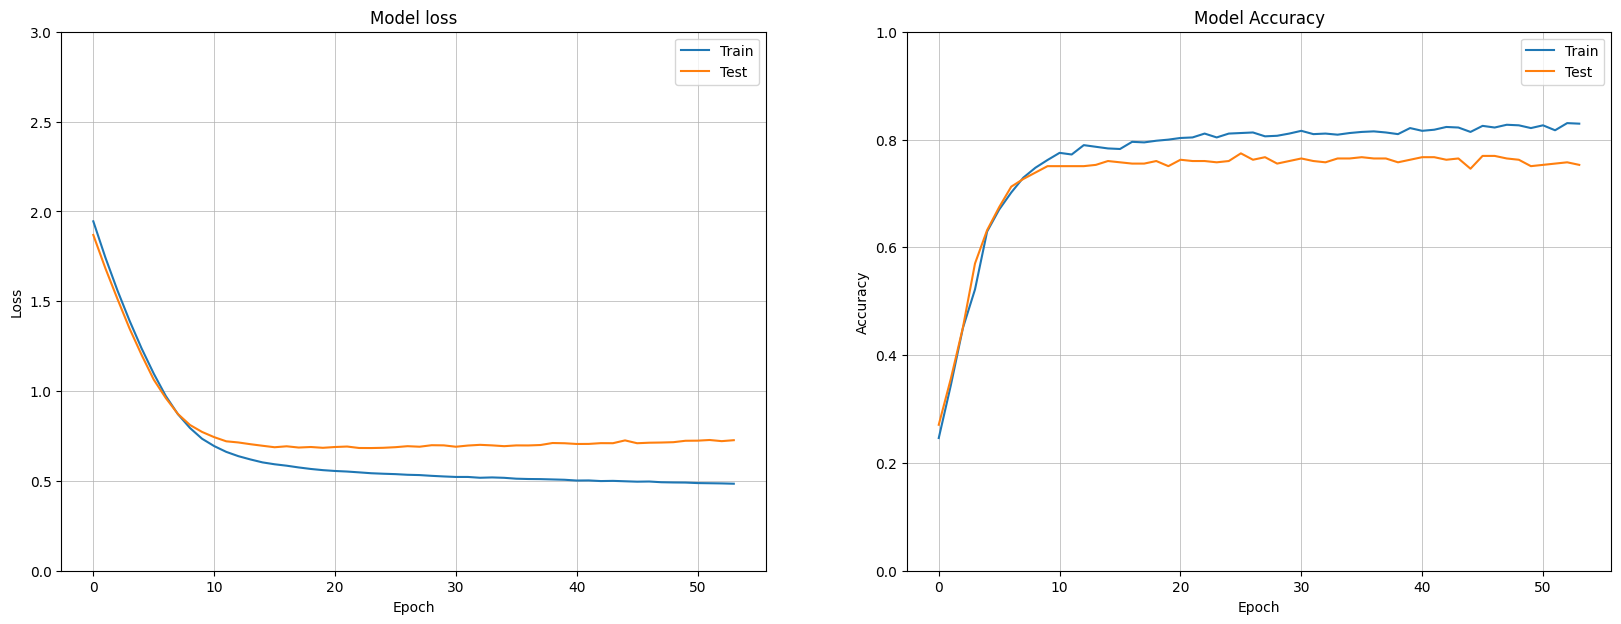

In [ ]:
%%time

# Initializing the Neural Network
model = initialize_model()

# Setting the patience term and restoring the best weights
es = EarlyStopping(patience = 30, restore_best_weights = True)

# Fitting the model and saving the training into a history variable
history = model.fit(
    X_train_scaled,
    y_train,
    validation_split = 0.3,
    epochs = 500,
    batch_size = 16, 
    verbose = 0, 
    callbacks = [es]
)

# Observing the loss and the metrics w.r.t. epochs
plot_loss_accuracy(history)

# Evaluating the model on the testing set
results = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f'The accuracy on the test set is of {results[1]:.2f}')

### (2.2) Batch Size & Epochs

 Let's investigate the impact of the batch size on training a Neural Network and how we can use it to control how fast the parameters are updated.

#### Playing with the Batch Size

Let's run the previous model with **different batch sizes** and plot the results.



2023-02-16 10:54:52.142034: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-16 10:54:59.298826: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-16 10:59:19.148814: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-16 10:59:19.628213: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-16 10:59:21.950330: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-16 11:00:52.314221: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-16 11:00:52.843826: I tensorflow/core/grappler/optimizers/cust

CPU times: user 6min 2s, sys: 1min 29s, total: 7min 31s
Wall time: 6min 21s


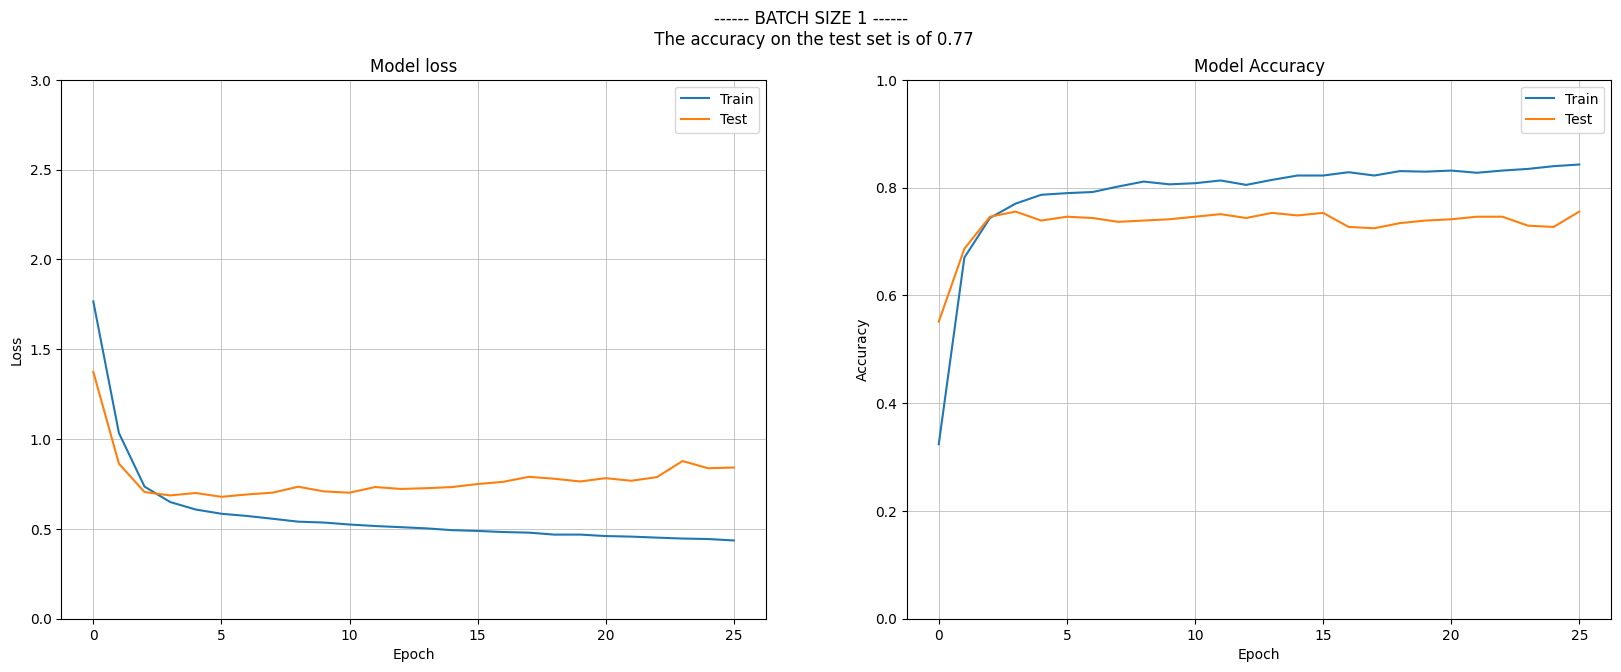

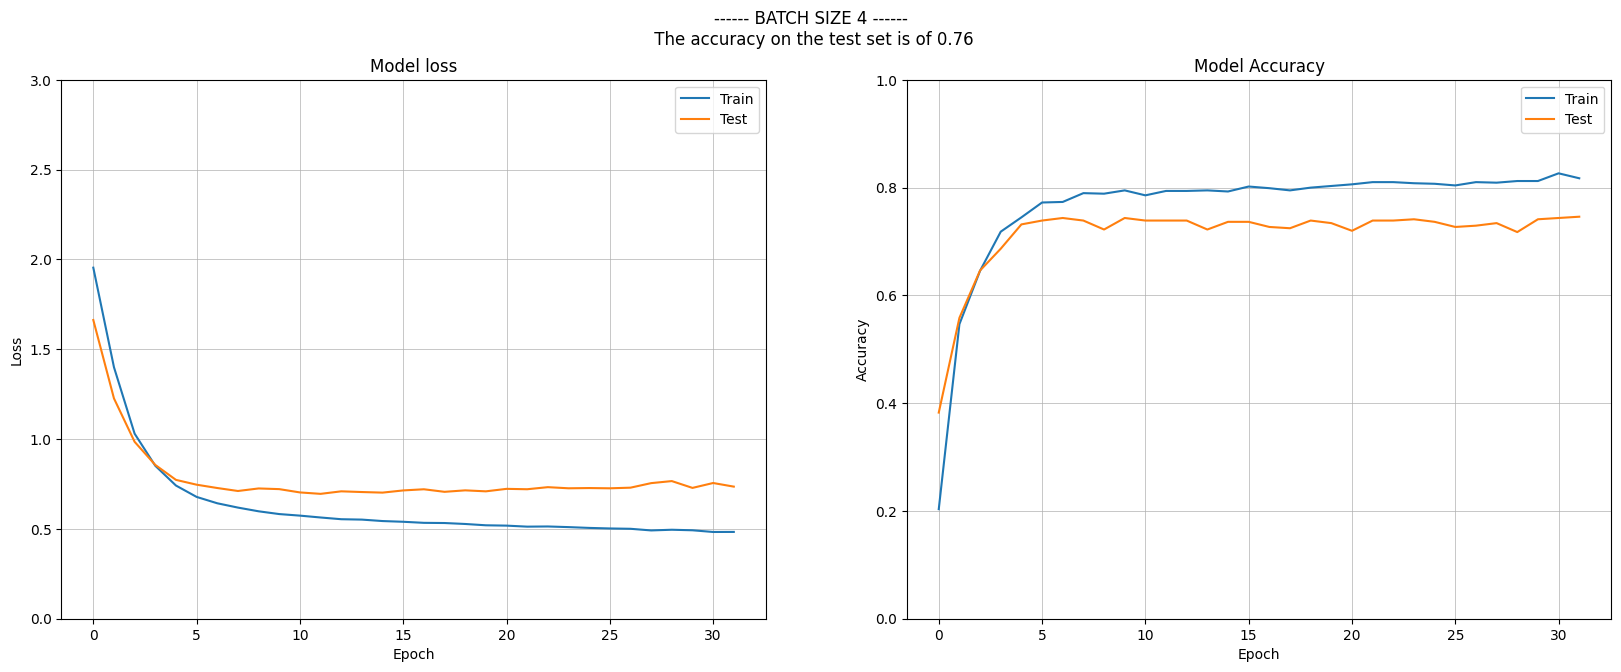

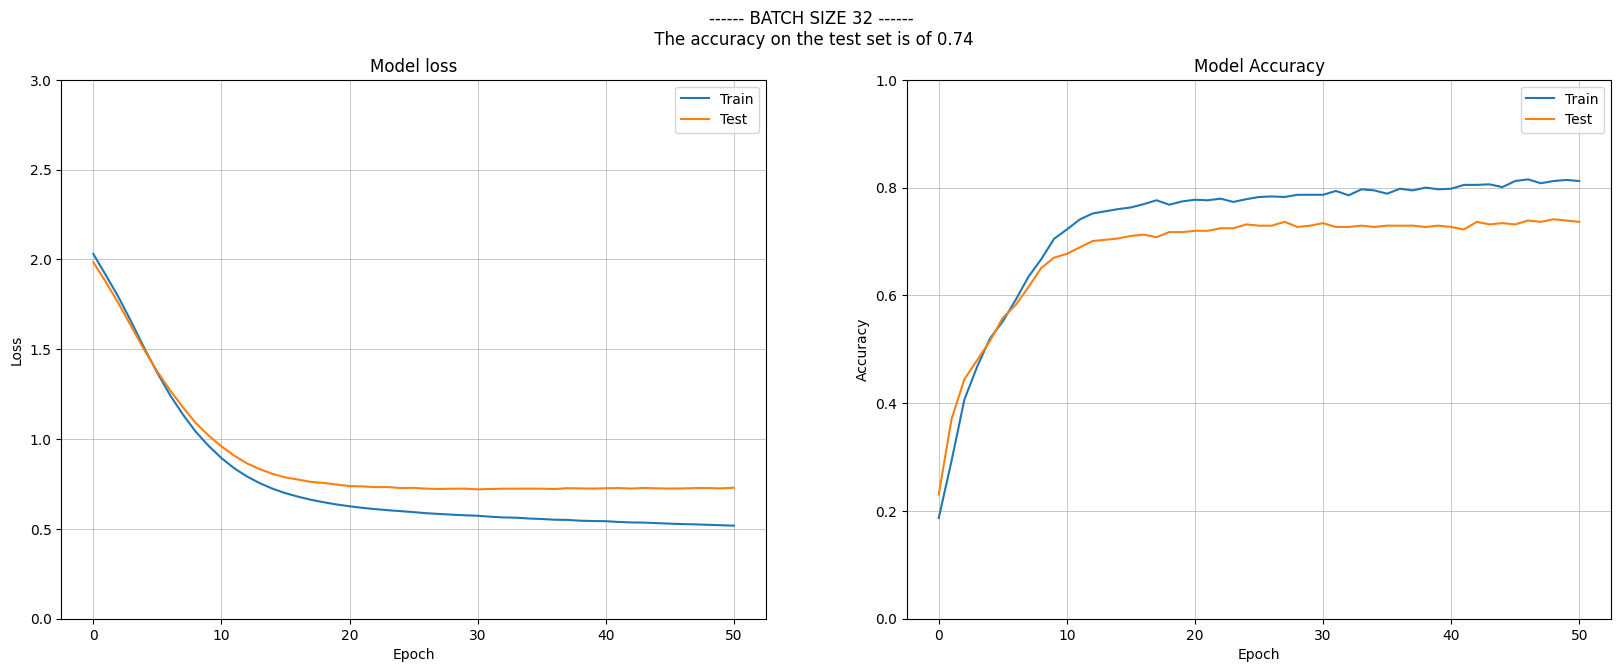

In [ ]:
%%time
# RUN THIS CELL
es = EarlyStopping(patience=20, restore_best_weights=True)

for batch_size in [1, 4, 32]:
    
    model = initialize_model()

    history = model.fit(
        X_train_scaled,
        y_train,
        validation_split = 0.3,
        epochs = 500,
        batch_size = batch_size, 
        verbose = 0, 
        callbacks = [es]
    )

    results = model.evaluate(X_test_scaled, y_test, verbose=0)
    plot_loss_accuracy(history, title=f'------ BATCH SIZE {batch_size} ------\n The accuracy on the test set is of {results[1]:.2f}')

### (2.3) Regularization

**Neural Networks with complex architectures can quickly lead to overfitting** 

 But since Dense Neural Networks are just activated linear regressions, the weights can be constrained using L1, L2, or L1-L2 penalties!

Let's apply some L2 or L1 penalties to these neurons; as in Machine Learning, these penalties are called **`Regularizers`**.



#### Observing Overfitting Before Regularizing

First, let's initialize a model that has too many parameters for the task such that it overfits the training data quickly. To that purpose, let's not use any Early Stopping criterion.


2023-02-16 11:01:16.331562: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-16 11:01:17.138521: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


The accuracy on the testing set is 0.71...
...whereas the accuracy on the training set is 0.84!


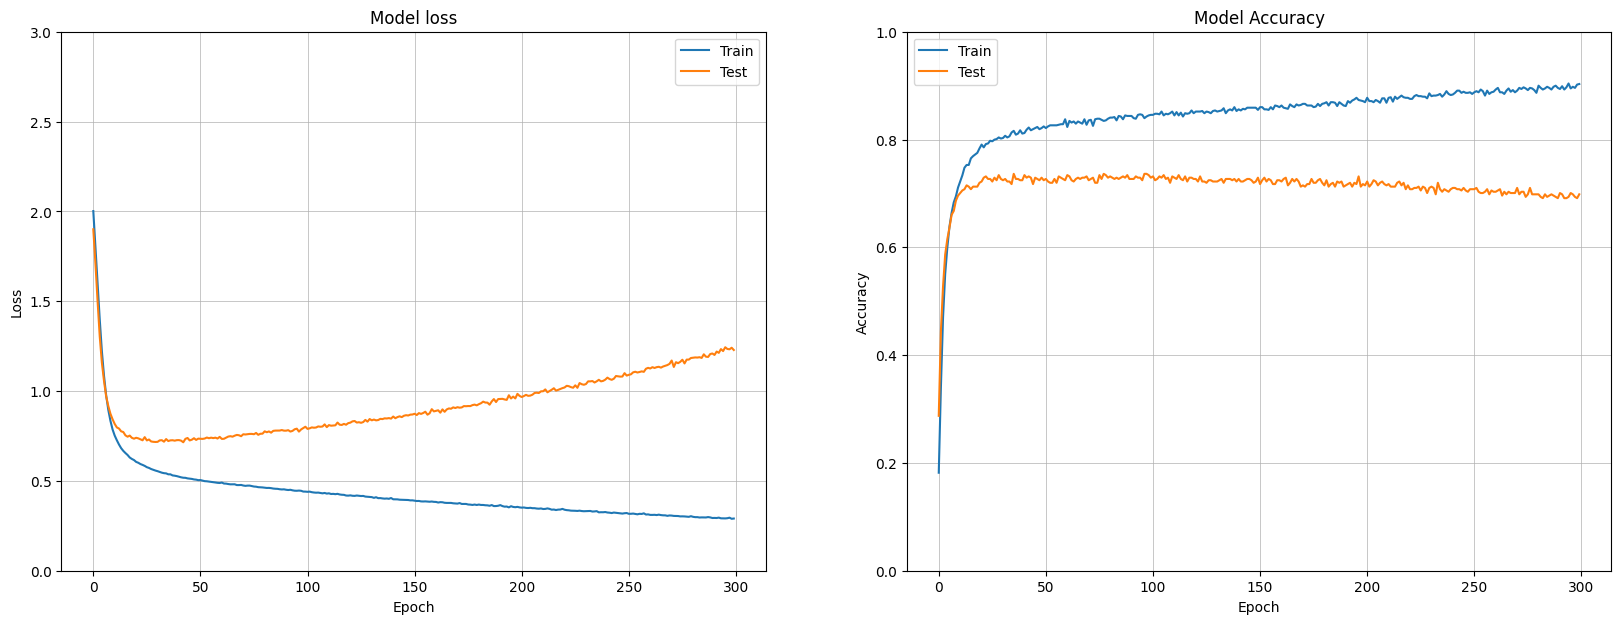

In [ ]:
# RUN THIS CELL

# 1. Model Architecture
model = models.Sequential()
model.add(layers.Dense(25, activation='relu', input_dim=10))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(8, activation='softmax'))

# 2. Model Compilation
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# 3. Training 
history = model.fit(
    X_train_scaled,
    y_train,
    validation_split = 0.3,
    epochs = 300,           # Notice that we are not using any Early Stopping Criterion
    batch_size = 16, 
    verbose=0
)

# 4. Evaluation
results_train = model.evaluate(X_train_scaled, y_train, verbose = 0)
results_test = model.evaluate(X_test_scaled, y_test, verbose = 0)


# 5. Looking back at what happened during the training phase
print(f'The accuracy on the testing set is {results_test[1]:.2f}...')
print(f'...whereas the accuracy on the training set is {results_train[1]:.2f}!')
plot_loss_accuracy(history)

In our "over-parameterized network", some neurons became **too specific for the given training data**, preventing the network from generalizing to new data.

This led to some overfitting.

#### Studying the Impact of Regularization on the Neural Network

Change the previous code to integrate an L2 or L1 regularizer into your Dense Layers.

2023-02-16 11:05:06.530797: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-16 11:05:07.476525: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Now, the accuracy on the testing set is 0.78...
...and the accuracy on the training set is 0.79!
The difference between the test accuracy and the train accuracy is much smaller when you regularize a Neural Network that used to overfit!


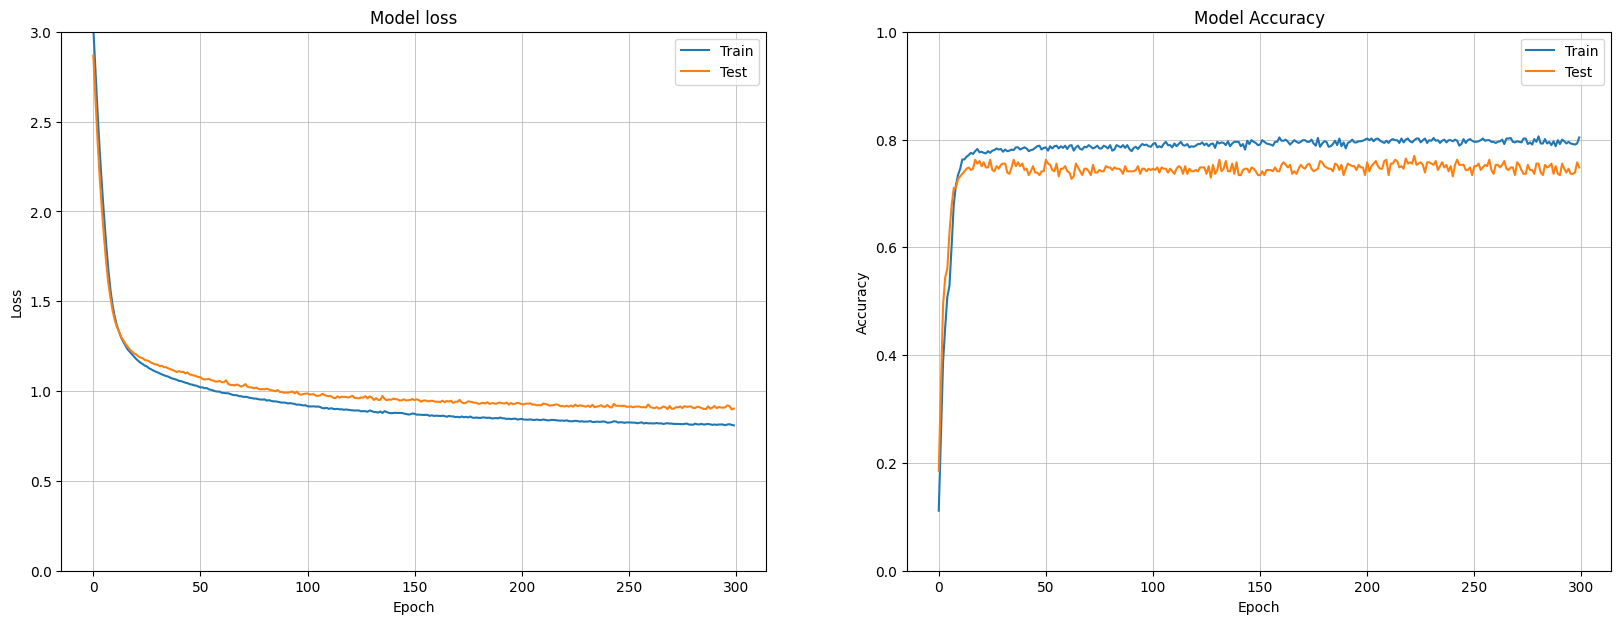

In [ ]:
# 0. Kernel Regularization
# Instantiating as an example an L1-regularizer with alpha = 0.01
reg_l1 = regularizers.L1(0.01)

# 1. Model Architecture
model = models.Sequential()
model.add(layers.Dense(25, activation='relu', input_dim=10, kernel_regularizer = reg_l1))
model.add(layers.Dense(10, activation='relu',  kernel_regularizer = reg_l1))
model.add(layers.Dense(8, activation='softmax'))


# 2. Model compilation
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# 3. Training 
history = model.fit(
    X_train_scaled,
    y_train,
    validation_split = 0.3,
    epochs = 300,           # Notice that we are not using any Early Stopping Criterion
    batch_size = 16, 
    verbose=0
)

# 4. Evaluation
results_train = model.evaluate(X_train_scaled, y_train, verbose=0)
results_test = model.evaluate(X_test_scaled, y_test, verbose=0)


# 5. Looking back at what happened during the training phase
print(f'Now, the accuracy on the testing set is {results_test[1]:.2f}...')
print(f'...and the accuracy on the training set is {results_train[1]:.2f}!')
print(f'The difference between the test accuracy and the train accuracy is much smaller when you regularize a Neural Network that used to overfit!')

plot_loss_accuracy(history)

### (2.4) Dropout Layers

#### Introduction to Dropout Layers

The role of a Dropout Layer is to randomly cancel the output of some neurons during the training phase, it prevents the network from getting too specific for the input data.

Dropout Layers
- ensure that no neuron can overspecialize in learning a pattern of the dataset because its output is sometimes canceled
- force the information of an input to be spread across multiple neurons instead of only one specific neuron
- are super straightforward to code 👌
  - but what is going on _under the hood_? 👩🏻‍🏫

#### Studying the Impact of Dropout Layers on the Neural Network

Include some Dropout layers in the architecture of your original model _(don't add regularizers here)_.

What can you observe regarding the convergence of your model? What about its ability to generalize?

2023-02-16 11:09:10.884601: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-16 11:09:11.793068: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Now, the accuracy on the test set is 0.75...
...and the accuracy on the training set is 0.79!
The difference between the test accuracy and the train accuracy is much smaller when you incorporate Dropout layers in the Neural Network !


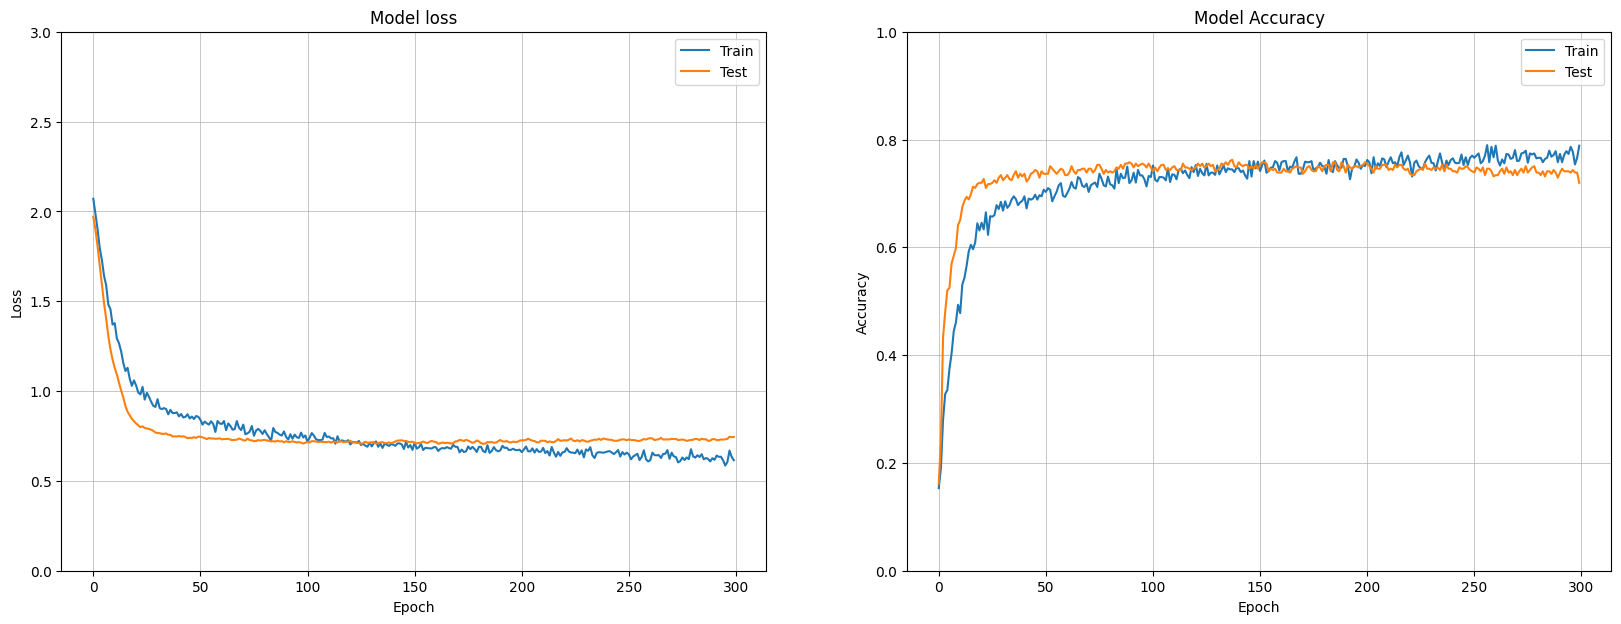

In [ ]:
# 1. Model Architecture including Dropout Layers
model = models.Sequential()
model.add(layers.Dense(25, activation='relu', input_dim=10))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(8, activation='softmax'))

# 2. Model compilation
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# 3. Training 
history = model.fit(
    X_train_scaled,
    y_train,
    validation_split = 0.3,
    epochs = 300,           # Notice that we are not using any Early Stopping Criterion
    batch_size = 16, 
    verbose=0
)

# 4. Evaluation
results_train = model.evaluate(X_train_scaled, y_train, verbose=0)
results_test = model.evaluate(X_test_scaled, y_test, verbose=0)


# 5. Looking back at what happened during the training phase
print(f'Now, the accuracy on the test set is {results_test[1]:.2f}...')
print(f'...and the accuracy on the training set is {results_train[1]:.2f}!')
print(f'The difference between the test accuracy and the train accuracy is much smaller when you incorporate Dropout layers in the Neural Network !')

plot_loss_accuracy(history)